In [1]:
from mlp import *
import matplotlib.pyplot as plt
from torch.autograd import Variable
from vgg import vgg16_bn,vgg11_bn
import torchvision.datasets as dsets
import pickle

In [3]:
def plot_me(yvalues,title,xerces,yaxis,xvalues=None):
    if xvalues is None:
        xs = [i for i in range(len(yvalues))]
    else:
        xs = xvalues
    plt.figure()
    h1, = plt.plot(xs,yvalues,"r")
    plt.legend(handles=[h1])
    plt.xlabel(xerces)
    plt.ylabel(yaxis)
    plt.title(title)
    plt.show()

In [4]:
def plot_you_and_me(yvalues1,yvalues2,title,xerces,yaxis,xvalues1=None,xvalues2=None,
                    label1=None,label2=None):
    if xvalues1 is None:
        xs1 = [i for i in range(len(yvalues1))]
    else:
        xs1 = xvalues1
    if xvalues2 is None:
        xs2= [i for i in range(len(yvalues2))]
    else:
        xs2 = xvalues2
    plt.figure()
    h1, = plt.plot(xs1,yvalues1,"r",label=label1)
    h2, = plt.plot(xs2,yvalues2,"b",label=label2)
    plt.legend(handles=[h1,h2])
    plt.xlabel(xerces)
    plt.ylabel(yaxis)
    plt.title(title)
    plt.show()

In [5]:
def get_acc(model,loader):
    acc = 0
    model.eval()
    for ex in loader:
        inputs,labels = ex
        inputs = Variable(inputs)
        labels = Variable(labels)
        acc += float(((torch.max(model(inputs),1)[1]==labels).float().mean())*100.0)
    acc /= len(loader)
    model.train()
    return acc

# 1. Regularization

In [15]:
#Training params
sizes = [784,800,800,10]
lr = 0.02
train_mbs = 64
test_mbs = 64
init_method = nn.init.xavier_normal
criterion = nn.CrossEntropyLoss()
epochs = 100
trainloader,testloader = load_MNIST(train_mbs,test_mbs)

## a) Early stopping and weight decay

### i. No regularization

/home/prenux/.local/lib/python3.6/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x63dea7b142b0> has a label of '_line0' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


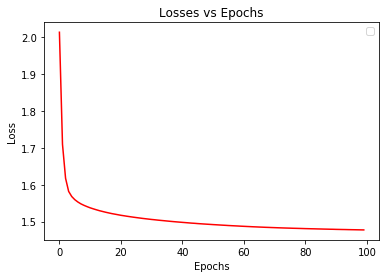

/home/prenux/.local/lib/python3.6/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x63de9ff187b8> has a label of '_line0' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


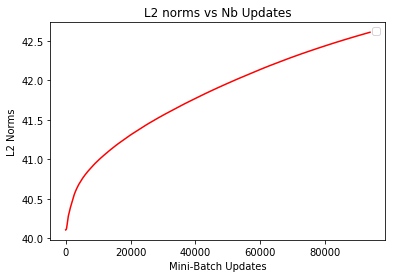

In [4]:
bengio = MLP(sizes,init_method)
optimizer = torch.optim.SGD(bengio.parameters(),lr=lr)
losses,norms = bengio.crazy_train(trainloader,epochs,criterion,optimizer,quiet=True)
plot_me(losses,"Losses vs Epochs","Epochs","Loss")
plot_me(norms,"L2 norms vs Nb Updates","Mini-Batch Updates","L2 Norms")

### ii. L2 regularization

/home/prenux/.local/lib/python3.6/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x63de9ff2fa58> has a label of '_line0' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


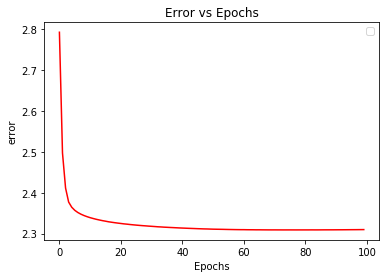

/home/prenux/.local/lib/python3.6/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x63dea7b4db00> has a label of '_line0' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


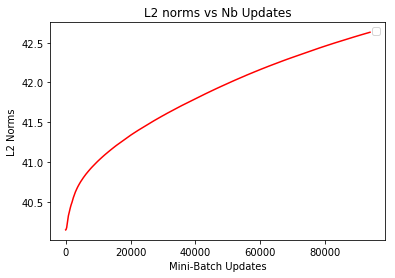

In [5]:
bengio = MLP(sizes,init_method)
optimizer = torch.optim.SGD(bengio.parameters(),lr=lr)
losses,norms = bengio.crazy_train(trainloader,epochs,criterion,optimizer,weight_decay=2.5,quiet=True)
plot_me(losses,"Error vs Epochs","Epochs","error")
plot_me(norms,"L2 norms vs Nb Updates","Mini-Batch Updates","L2 Norms")

## b) Dropout

In [16]:
# Train
bengio = MLP(sizes,init_method,dropout_last=True,apply_smax=False)
optimizer = torch.optim.SGD(bengio.parameters(),lr=lr)
losses,norms = bengio.crazy_train(trainloader,epochs,criterion,optimizer,quiet=True)

### i. Multiplying by 0.5

Accuracy (%) : 97.38999938964844
Accuracy (%) : 97.38999938964844
Accuracy (%) : 97.38999938964844
Accuracy (%) : 97.38999938964844
Accuracy (%) : 97.38999938964844
Accuracy (%) : 97.38999938964844
Accuracy (%) : 97.38999938964844
Accuracy (%) : 97.38999938964844
Accuracy (%) : 97.38999938964844
Accuracy (%) : 97.38999938964844


/home/prenux/.local/lib/python3.6/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x62a3aeb823c8> has a label of '_line0' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


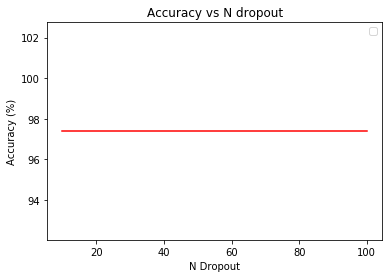

In [17]:
bengio.set_apply_smax(True)
bengio.eval()
acc = []
for n in range(10,110,10):
    tmp = []
    for test in testloader:
        inputs,labels = test
        inputs = Variable(inputs)
        labels = Variable(labels)
        tmp.append(torch.max(bengio(inputs),1)[1]==labels)
    a = float(torch.cat(tmp).float().mean()*100.0)
    print("Accuracy (%) :", a)
    acc.append(a)
plot_me(acc,"Accuracy vs N dropout","N Dropout","Accuracy (%)",xvalues=list(range(10,110,10)))

### ii. N dropout and average pre-softmax

Accuracy (%) : 11.920000076293945
Accuracy (%) : 11.710000038146973
Accuracy (%) : 11.84000015258789
Accuracy (%) : 11.99000072479248
Accuracy (%) : 11.980000495910645
Accuracy (%) : 11.569999694824219
Accuracy (%) : 11.940000534057617
Accuracy (%) : 12.319999694824219
Accuracy (%) : 11.860000610351562
Accuracy (%) : 12.100000381469727


/home/prenux/.local/lib/python3.6/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x62a3ad09b128> has a label of '_line0' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


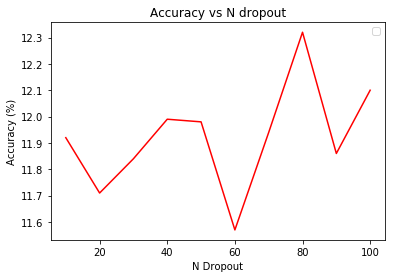

In [18]:
bengio.set_apply_smax(False)
bengio.train()
acc = []
for n in range(10,110,10):
    tmp = []
    for test in testloader:
        tmp2 = []
        for i in range(n):
            inputs,labels = test
            inputs = Variable(inputs)
            labels = Variable(labels)
            tmp2.append(bengio(inputs))
        meaned = torch.cat(tmp2).mean(dim=0)
        smax = F.softmax(meaned.view(-1,10),dim=1)
        tmp.append(torch.max(smax,1)[1]==labels)
    a = float(torch.cat(tmp).float().mean()*100.0)
    print("Accuracy (%) :", a)
    acc.append(a)
plot_me(acc,"Accuracy vs N dropout","N Dropout","Accuracy (%)",xvalues=list(range(10,110,10)))

### iii. N dropout and average predictions

Accuracy (%) : 9.550000190734863
Accuracy (%) : 10.130000114440918
Accuracy (%) : 9.630000114440918
Accuracy (%) : 10.019999504089355
Accuracy (%) : 9.800000190734863
Accuracy (%) : 9.859999656677246
Accuracy (%) : 9.630000114440918
Accuracy (%) : 9.90999984741211
Accuracy (%) : 10.029999732971191
Accuracy (%) : 10.199999809265137


/home/prenux/.local/lib/python3.6/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x62a3acffa8d0> has a label of '_line0' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


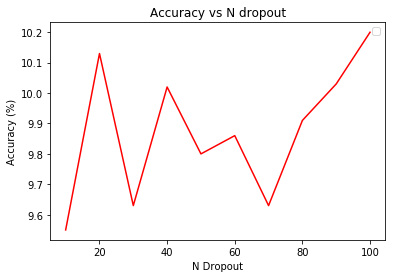

In [19]:
bengio.set_apply_smax(True)
bengio.train()
acc = []
for n in range(10,110,10):
    tmp = []
    for test in testloader:
        tmp2 = []
        for i in range(n):
            inputs,labels = test
            inputs = Variable(inputs)
            labels = Variable(labels)
            tmp2.append(torch.max(bengio(inputs),1)[1])
        pred = int(torch.cat(tmp2).float().mean())
        tmp.append(pred==labels)
    a = float(torch.cat(tmp).float().mean()*100.0)
    print("Accuracy (%) :", a)
    acc.append(a)
plot_me(acc,"Accuracy vs N dropout","N Dropout","Accuracy (%)",xvalues=list(range(10,110,10)))

The accuracy of the last two models seems very low in comparison with the first model. Chances are we messed it up somewhere in the code, but since we do not have high performance computing, we can't run it again and again to debug the problem yet. It seems like this is almost the error that has been plotted for the last two instead of the accuracy...

### These weird results apart, we may consider the first model being some kind of bagging method

## c) Convolutional networks

In [17]:
mnist_transforms = torchvision.transforms.Compose([torchvision.transforms.ToTensor()])

mnist_train = torchvision.datasets.MNIST(root='./data', train=True, transform=mnist_transforms, download=True)
mnist_test = torchvision.datasets.MNIST(root='./data', train=False, transform=mnist_transforms, download=True)

trainloader = torch.utils.data.DataLoader(mnist_train, batch_size=128, shuffle=True, num_workers=4)
testloader = torch.utils.data.DataLoader(mnist_test, batch_size=64, shuffle=True, num_workers=2)

In [18]:
#Training params
lr = 0.02
criterion = nn.CrossEntropyLoss()
epochs = 10

In [23]:
def train_convnet(model,trainloader,epochs,optimizer,criterion,testloader):
    train_errs = []
    test_errs = []
    for epoch in range(epochs):  # loop over the dataset multiple times
        running_train_err = 0
        running_test_err = 0
        for i, data in enumerate(trainloader):
            # get the inputs
            inputs, labels = data
            # wrap them in Variable
            inputs, labels = Variable(inputs), Variable(labels)
            # zero the parameter gradients
            optimizer.zero_grad()
            # forward + backward + optimize
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
        mean_train_err = 100 - get_acc(model,trainloader)
        mean_test_err = 100 - get_acc(model,testloader)
        print('[%d] Mean Train Error: %.3f' % (epoch, mean_train_err))
        print('[%d] Mean Test Error: %.3f' % (epoch, mean_test_err))
        train_errs.append(mean_train_err)
        test_errs.append(mean_test_err)
    print('Finished Training')
    return train_errs,test_errs

### i. ConvNet Batch Norm

In [31]:
class ConvNetBN(nn.Module):
    """Convnet Classifier"""
    def __init__(self):
        super(ConvNetBN, self).__init__()
        self.conv = nn.Sequential(
            # Layer 1
            nn.BatchNorm2d(1),
            nn.Conv2d(in_channels=1, out_channels=16, kernel_size=(3, 3), padding=1),
            nn.Dropout(p=0.5),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=(2, 2), stride=2),
            # Layer 2
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=(3, 3), padding=1),
            nn.Dropout(p=0.5),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=(2, 2), stride=2),
            # Layer 3
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=(3, 3), padding=1),
            nn.Dropout(p=0.5),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=(2, 2), stride=2),
            # Layer 4
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=(3, 3), padding=1),
            nn.Dropout(p=0.5),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=(2, 2), stride=2)
        )
        # Logistic Regression
        self.clf = nn.Linear(128, 10)

    def forward(self, x):
        return self.clf(self.conv(x).squeeze())

In [32]:
bengioCN = ConvNetBN()
optimizer_bn = torch.optim.Adam(bengioCN.parameters(), lr=1e-4)
train_errs_bn,test_errs_bn = train_convnet(bengioCN,trainloader,epochs,optimizer_bn,criterion,testloader)
torch.save(bengioCN.state_dict(), "models/bengioCN_bn.sav")

[0] Mean Train Error: 8.130
[0] Mean Test Error: 7.424
[1] Mean Train Error: 5.203
[1] Mean Test Error: 4.887
[2] Mean Train Error: 3.967
[2] Mean Test Error: 3.732
[3] Mean Train Error: 3.208
[3] Mean Test Error: 2.996
[4] Mean Train Error: 2.862
[4] Mean Test Error: 2.707
[5] Mean Train Error: 2.631
[5] Mean Test Error: 2.329
[6] Mean Train Error: 2.397
[6] Mean Test Error: 2.199
[7] Mean Train Error: 2.292
[7] Mean Test Error: 2.170
[8] Mean Train Error: 2.235
[8] Mean Test Error: 2.130
[9] Mean Train Error: 1.978
[9] Mean Test Error: 1.821
Finished Training


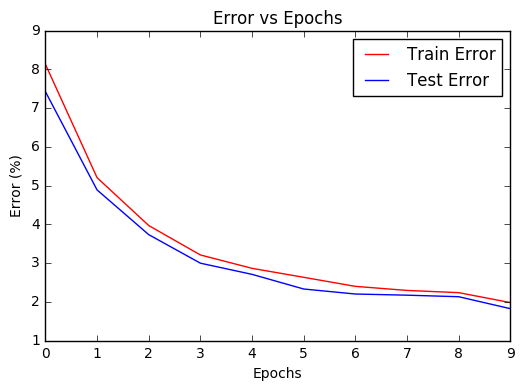

In [33]:
plot_you_and_me(train_errs_bn,test_errs_bn,"Error vs Epochs","Epochs","Error (%)",label1="Train Error",label2="Test Error")

### ii. ConvNet No Batch Norm

In [27]:
class ConvNet(nn.Module):
    """Convnet Classifier"""
    def __init__(self):
        super(ConvNet, self).__init__()
        self.conv = nn.Sequential(
            # Layer 1
            nn.Conv2d(in_channels=1, out_channels=16, kernel_size=(3, 3), padding=1),
            nn.Dropout(p=0.5),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=(2, 2), stride=2),
            # Layer 2
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=(3, 3), padding=1),
            nn.Dropout(p=0.5),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=(2, 2), stride=2),
            # Layer 3
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=(3, 3), padding=1),
            nn.Dropout(p=0.5),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=(2, 2), stride=2),
            # Layer 4
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=(3, 3), padding=1),
            nn.Dropout(p=0.5),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=(2, 2), stride=2)
        )
        # Logistic Regression
        self.clf = nn.Linear(128, 10)

    def forward(self, x):
        return self.clf(self.conv(x).squeeze())

In [29]:
bengioCN2 = ConvNet()
optimizer = torch.optim.Adam(bengioCN2.parameters(), lr=1e-4)
train_errs,test_errs = train_convnet(bengioCN2,trainloader,epochs,optimizer,criterion,testloader)
torch.save(bengioCN.state_dict(), "models/bengioCN.sav")

[0] Mean Train Error: 14.936
[0] Mean Test Error: 14.122
[1] Mean Train Error: 7.985
[1] Mean Test Error: 7.265
[2] Mean Train Error: 6.146
[2] Mean Test Error: 5.533
[3] Mean Train Error: 5.148
[3] Mean Test Error: 4.568
[4] Mean Train Error: 4.302
[4] Mean Test Error: 3.822
[5] Mean Train Error: 3.956
[5] Mean Test Error: 3.354
[6] Mean Train Error: 3.680
[6] Mean Test Error: 3.264
[7] Mean Train Error: 3.271
[7] Mean Test Error: 2.836
[8] Mean Train Error: 3.184
[8] Mean Test Error: 2.727
[9] Mean Train Error: 2.855
[9] Mean Test Error: 2.478
Finished Training


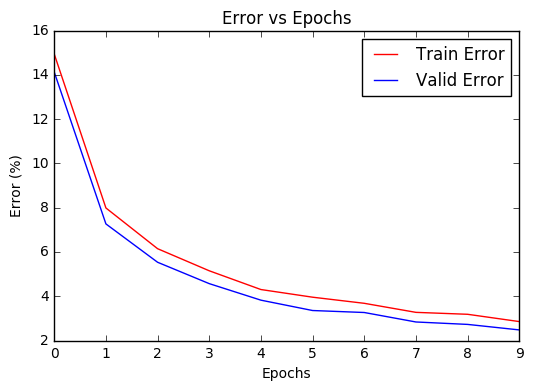

In [30]:
plot_you_and_me(train_errs,test_errs,"Error vs Epochs","Epochs","Error (%)",label1="Train Error",label2="Valid Error")

# Cats and Dogs

In [6]:
class TrainData():
    def __init__(self,best_valid_error,valid_errors,train_errors,losses,count):
        self.best_valid_error = best_valid_error
        self.valid_errors = valid_errors
        self.train_errors = train_errors
        self.losses = losses
        self.count = count

# train model, print running_loss at end of each epoch
def train_it(model,epochs,optimizer,criterion,meni,
              trainloader,validloader,model_name,train_data_file=None):
    best_valid_error = 100
    valid_errors = []
    train_errors = []
    losses = []
    count = 0
    epochs = [epochs]
    if train_data_file:
        with open(train_data_file, "rb") as train_data:
            train_data = pickle.load(train_data)
            best_valid_error = train_data.best_valid_error
            valid_errors = train_data.valid_errors
            train_errors = train_data.train_errors
            losses = train_data.losses
            count = train_data.count
            epochs = [len(losses)] + epochs
            for e,l in enumerate(losses):
                print('[%d] Mean Train loss: %.3f' % (e, l))
    for epoch in range(*epochs):
        running_loss = 0.0
        for data in trainloader:
            inputs, labels = data
            if torch.cuda.is_available():
                inputs, labels = inputs.cuda(), labels.cuda()
            inputs, labels = Variable(inputs), Variable(labels)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.data[0]
        # update best validation error
        valid_error = 100 - get_acc(model, validloader)
        if valid_error < best_valid_error:
            best_valid_error = valid_error
            count = 0
        else:
            count += 1
            if count >= meni:
                break
        valid_errors.append(valid_error)
        train_errors.append(100 - get_acc(model,trainloader))
        mean_loss = running_loss/len(trainloader)
        losses.append(mean_loss)
        print('[%d] Mean Train loss: %.3f' % (epoch, mean_loss))
        # Save model and training data each 10 epochs
        if epoch % 10 == 0:
            with open('models/{}-train_data_{}.pkl'.format(model_name,epoch), 'wb') as output:
                train_data = TrainData(best_valid_error,valid_errors,train_errors,losses,count)
                pickle.dump(train_data, output, pickle.HIGHEST_PROTOCOL)
            torch.save(bengio.state_dict(), "models/{}-{}.sav".format(model_name,epoch))
    print('Finished Training')
    with open('{}-train_data_finisged.pkl'.format(model_name), 'wb') as output:
        train_data = TrainData(best_valid_error,valid_errors,train_errors,losses,count)
        pickle.dump(train_data, output, pickle.HIGHEST_PROTOCOL)
    torch.save(bengio.state_dict(), "models/{}-finished.sav".format(model_name))
    return losses,train_errors,valid_errors

In [7]:
# Parameters, uses early_stopping, transfer_learning & nesterov
lr = 0.02
wd = 5 * 10**(-4)
mom = 0.9
epochs = 100

# global params
train_errors = []
valid_errors = []
#max_epoch_no_improvement (for early stopping)
meni = 5

In [8]:
# Load 224 x 224 images and normalize them (as suggested on PyTorch doc) 
# Training set size: 15569
# Validation set size: 5000
# Test set size: 4432

size = 64
bs = 1000

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

trainset = dsets.ImageFolder(root='data/kaggle/train_{0}x{0}'.format(size),transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=bs,shuffle=True, num_workers=2)

validset = dsets.ImageFolder(root='data/kaggle/valid_{0}x{0}'.format(size),transform=transform)
validloader = torch.utils.data.DataLoader(validset, batch_size=bs,shuffle=True, num_workers=2)

testset = dsets.ImageFolder(root='data/kaggle/test_{0}x{0}'.format(size),transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=bs,shuffle=True, num_workers=2)

In [9]:
def make_layers(cfg, batch_norm=False):
    layers = []
    in_channels = 3
    for v in cfg:
        if v == 'M':
            layers += [nn.MaxPool2d(kernel_size=2, stride=2)]
        else:
            conv2d = nn.Conv2d(in_channels, v, kernel_size=3, padding=1)
            if batch_norm:
                layers += [conv2d, nn.BatchNorm2d(v), nn.ReLU(inplace=True)]
            else:
                layers += [conv2d, nn.ReLU(inplace=True)]
            in_channels = v
    return nn.Sequential(*layers)

class CatEgorizer(nn.Module):
    """Inspired by pytorch torchvision.models.vgg"""
    def __init__(self,convnet,n_classes):
        super(CatEgorizer, self).__init__()
        self.conv = convnet
        # Logistic Regression
        self.classifier = nn.Sequential(
            nn.Linear(8192, 4096),
            nn.ReLU(True),
            nn.Dropout(),
            nn.Linear(4096, 4096),
            nn.ReLU(True),
            nn.Dropout(),
            nn.Linear(4096, n_classes),
        )
        self._initialize_weights()
        
    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                n = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
                m.weight.data.normal_(0, math.sqrt(2. / n))
                if m.bias is not None:
                    m.bias.data.zero_()
            elif isinstance(m, nn.BatchNorm2d):
                m.weight.data.fill_(1)
                m.bias.data.zero_()
            elif isinstance(m, nn.Linear):
                m.weight.data.normal_(0, 0.01)
                m.bias.data.zero_()

    def forward(self, x):
        x = self.conv(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x

In [9]:
# Load model (VGG model from pytorch library with pretrained layers with batch norm)
'''
Can't afford to train this, would take over too long
Please forgive us or give us some good GPUs.
We also accept paypal and interac fund transfers.
'''
#bengio = vgg16_bn()
'''
Same thing with this one...
'''
#bengio = vgg11_bn()

cfg = [64,'M',128,'M',256,'M',512,'M']
convnet = make_layers(cfg,True)
bengio = CatEgorizer(convnet,2)

optimizer = torch.optim.SGD(bengio.parameters(),lr=lr, momentum=mom, weight_decay=wd, nesterov=True)
criterion = nn.CrossEntropyLoss() # or crossentropy with 2 classes, need labels as 0 and 1

In [10]:
if torch.cuda.is_available():
    bengio.cuda()

# When training stopped because of system halt restore last check point
# by giving check point of training data and model state dict
#train_data_file = "train_data.pkl"
#model_file = "models/bengioVGG-20.sav"
#bengio.load_state_dict(torch.load(model_file))

l,t,v = train_it(bengio,epochs,optimizer,criterion,meni,trainloader,validloader,"bengioVGG",train_data_file=train_data_file)

[0] Mean Train loss: 1.142
[1] Mean Train loss: 0.635
[2] Mean Train loss: 0.590
[3] Mean Train loss: 0.529
[4] Mean Train loss: 0.528
[5] Mean Train loss: 0.489
[6] Mean Train loss: 0.453
[7] Mean Train loss: 0.444
[8] Mean Train loss: 0.423
[9] Mean Train loss: 0.392
[10] Mean Train loss: 0.351
[11] Mean Train loss: 0.396
[12] Mean Train loss: 0.334
[13] Mean Train loss: 0.322
[14] Mean Train loss: 0.330
[15] Mean Train loss: 0.297
[16] Mean Train loss: 0.288
[17] Mean Train loss: 0.287
[18] Mean Train loss: 0.278
[19] Mean Train loss: 0.330
[20] Mean Train loss: 0.309
[21] Mean Train loss: 0.220
[22] Mean Train loss: 0.283
[23] Mean Train loss: 0.414
[24] Mean Train loss: 0.232
Finished Training


## a) Architecture

Based on the architecture of pytorch VGGs, we built some small VGG-like model since vgg16 and even vgg11 would have taken too long to train on google cloud with CPU (since we have to pay 70$ upon GPU quota increase request). So this results in a not so bad but not really good either.

The convolutional part is constructed sequentially as this : 64,'M',128,'M',256,'M',512,'M'. Each number is the number of feature maps generated by the convolution (all with kernel size of 3, padding of 1 and stride of 1 also). The 'M' are maxpooling layers with kernel size of 2 and stride of 2. These layers parameters are taken from VGG implementation of torchvision.models.

After this the results of the convolutional part are passed to an MLP part which is responsible of the classification based on the features extracted by the convolutional part. Again many numbers were taken from torchvision.models in hope to get better results on the first run, since two runs might not be possible in time.

While asked for 100 epochs, the model stopped at 25 because of early stopping with a max_epoch_no_improve = 5 (aka meni). That means if after 5 epochs since is best validation error, the model has not got a better value the training stops.

Batch norm was used in the convolutional part and dropout in the MLP part accordingly to torchvision.models (again...).

## b) Error

/home/remi_langevin2/anaconda3/lib/python3.5/site-packages/matplotlib/axes/_axes.py:518: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f1700044ba8> has a label of '_line0' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


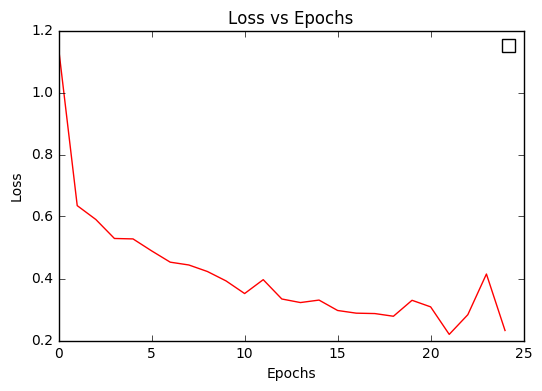

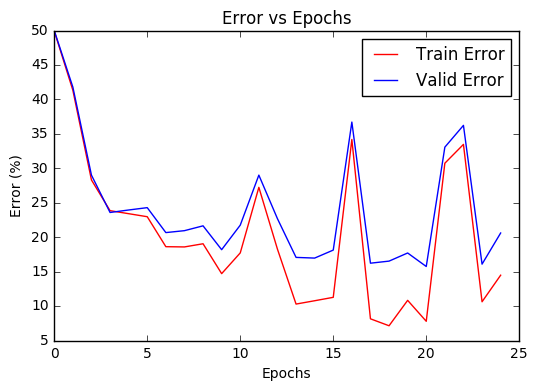

In [12]:
plot_me(l,"Loss vs Epochs","Epochs","Loss")
plot_you_and_me(t,v,"Error vs Epochs","Epochs","Error (%)",label1="Train Error",label2="Valid Error")

## c) Comparisons and report

In [10]:
cfg = [64,'M',128,'M',256,'M',512,'M']
convnet = make_layers(cfg,True)
bengio = CatEgorizer(convnet,2)
model_file = "models/bengioVGG-finished.sav"
bengio.load_state_dict(torch.load(model_file))

### Feature maps

Noise


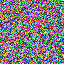

Random input image


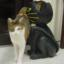

Features of first conv layer (Conv only, NO batch_norm nor relu nor maxpooling)
randomly choosen fm

Conv2d (3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))


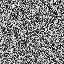

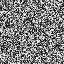

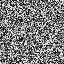

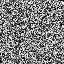

Features of first Nth conv layer (before last maxpooling (makes it too small))
randomly choosen fm

N = 1
Conv2d (3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
ReLU(inplace)
torch.Size([1, 64, 64, 64])


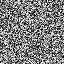

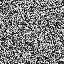

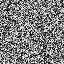

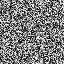

In [11]:
import PIL
import IPython.display as dp
from IPython.display import Image
from torchvision.transforms import ToPILImage,ToTensor
from random import randint

bengio.eval()

to_img = ToPILImage()
to_tensor = ToTensor()

# display tensor
print("Noise")
a = torch.Tensor(3, 64, 64).normal_()
dp.display(to_img(a))

print("Random input image")
max_i = len(trainset)
img_i = randint(0,max_i-1)
dp.display(Image(filename=trainset.imgs[img_i][0]))

# Same random image
img = to_tensor(PIL.Image.open(trainset.imgs[img_i][0])).view(1,3,64,64)

print("Features of first conv layer (Conv only, NO batch_norm nor relu nor maxpooling)\nrandomly choosen fm\n")
print(bengio.conv[0])
res = bengio.conv[0](Variable(img))
res = res.view(64,64,64)
for i in range(4):
    k = res[randint(0,63)]
    a = k.view(1,64,64).data.normal_()
    dp.display(to_img(a))

print("Features of first Nth conv layer (before last maxpooling (makes it too small))\nrandomly choosen fm\n")
n = 1
print("N =",n)
res = Variable(img.view(1,3,64,64))
for i in range(n*4 -1):
    print(bengio.conv[i])
    res = bengio.conv[i](res)
print(res.shape)
shape = res.shape[-1]
res = res.view(res.shape[1],res.shape[2],res.shape[3])
for i in range(4):
    k = res[randint(0,res.shape[1]-1)]
    a = k.view(1,shape,shape).data.normal_()
    dp.display(to_img(a))

bengio.train()
print()

The feature maps do not seem quite interesting, probably due to the normalization applied on input (see next cells)

### Misclassified examples

In [31]:
size = 64
transform = transforms.Compose([
    transforms.ToTensor()
    ])
testset_bs_1 = dsets.ImageFolder(root='data/kaggle/test_{0}x{0}'.format(size),transform=transform)
testloader_bs_1 = torch.utils.data.DataLoader(testset_bs_1, batch_size=1,shuffle=True, num_workers=2)

label: 1
prediction: 0
Source image:


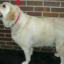

Normalized image:


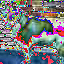

label: 0
prediction: 1
Source image:


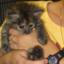

Normalized image:


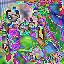

label: 0
prediction: 1
Source image:


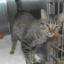

Normalized image:


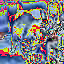

label: 0
prediction: 1
Source image:


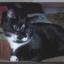

Normalized image:


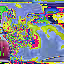

label: 0
prediction: 1
Source image:


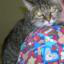

Normalized image:


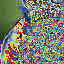

label: 0
prediction: 1
Source image:


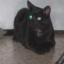

Normalized image:


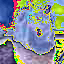

label: 0
prediction: 1
Source image:


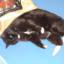

Normalized image:


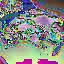

label: 1
prediction: 0
Source image:


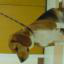

Normalized image:


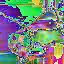

label: 1
prediction: 0
Source image:


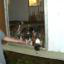

Normalized image:


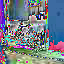

label: 1
prediction: 0
Source image:


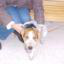

Normalized image:


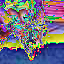

label: 0
prediction: 1
Source image:


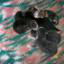

Normalized image:


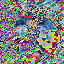

In [48]:
import PIL
import IPython.display as dp
from IPython.display import Image
from torchvision.transforms import ToPILImage,ToTensor
to_img = ToPILImage()
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])

bengio.eval()

FEED_NORMALIZED = True

wrongs = []
for img,labels in testloader_bs_1:
    orig = img.clone()
    sizes = [img.shape[1],img.shape[2],img.shape[3]]
    if FEED_NORMALIZED:
        inputs, labels = Variable(normalize(img.view(*sizes)).view(1,*sizes)), Variable(labels)
    else:
        inputs, labels = Variable(img), Variable(labels)
    outputs = bengio(inputs)
    preds = torch.max(outputs,1)[1]
    is_good = float((preds==labels).float().mean())
    if is_good == 0:
        wrongs.append( (orig, int(labels.data), int(preds)) )
    if len(wrongs) > 10:
        break

bengio.train()

for i,l,p in wrongs:
    print("label:",l)
    print("prediction:",p)
    i = i.view(i.shape[1],i.shape[2],i.shape[3])
    print("Source image:")
    dp.display(to_img(i))
    print("Normalized image:")
    dp.display(to_img(normalize(i)))

### Weird stuff:

All wrong guesses involves dogs, all cats are perfectly classified if input is not normalized ... but training was made on normalized images

### Ambiguous examples

/usr/lib/python3.6/site-packages/ipykernel_launcher.py:20: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


label: 1
cat: 52.29563117027283 %
dog: 47.704362869262695 %
Source image:


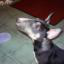

Normalized image:


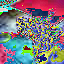

label: 0
cat: 51.617616415023804 %
dog: 48.382386565208435 %
Source image:


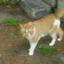

Normalized image:


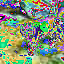

label: 1
cat: 49.184420704841614 %
dog: 50.81557631492615 %
Source image:


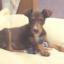

Normalized image:


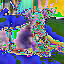

label: 0
cat: 52.01334357261658 %
dog: 47.98665642738342 %
Source image:


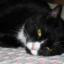

Normalized image:


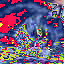

label: 1
cat: 52.13562250137329 %
dog: 47.86437451839447 %
Source image:


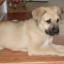

Normalized image:


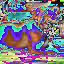

label: 1
cat: 49.073463678359985 %
dog: 50.926536321640015 %
Source image:


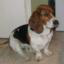

Normalized image:


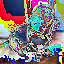

label: 0
cat: 47.885510325431824 %
dog: 52.114492654800415 %
Source image:


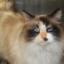

Normalized image:


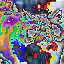

label: 1
cat: 50.00056028366089 %
dog: 49.99944269657135 %
Source image:


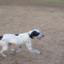

Normalized image:


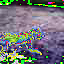

label: 0
cat: 47.960227727890015 %
dog: 52.039772272109985 %
Source image:


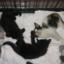

Normalized image:


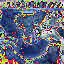

label: 0
cat: 51.32836699485779 %
dog: 48.67163598537445 %
Source image:


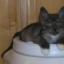

Normalized image:


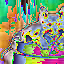

label: 1
cat: 51.01290941238403 %
dog: 48.987093567848206 %
Source image:


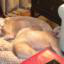

Normalized image:


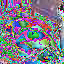

In [73]:
import PIL
import IPython.display as dp
from IPython.display import Image
from torchvision.transforms import ToPILImage,ToTensor
to_img = ToPILImage()
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])

bengio.eval()

FEED_NORMALIZED = True

amb = []
for img,labels in testloader_bs_1:
    orig = img.clone()
    sizes = [img.shape[1],img.shape[2],img.shape[3]]
    if FEED_NORMALIZED:
        inputs, labels = Variable(normalize(img.view(*sizes)).view(1,*sizes)), Variable(labels)
    else:
        inputs, labels = Variable(img), Variable(labels)
    outputs = F.softmax(bengio(inputs).view(-1)).data
    c = outputs[0] * 100
    d = outputs[1] * 100
    if (c+d)/100 < 0.99 or (c+d)/100 > 1.01:
        print("error total prob not between 0.99 and 1.01:")
        print(c)
        print(d)
        break
    if abs(c-d) < 5:
        amb.append( (orig, int(labels.data),c,d) )
    if len(amb) > 10:
        break

bengio.train()

for i,l,c,d in amb:
    print("label:",l)
    print("cat:",c,"%")
    print("dog:",d,"%")
    i = i.view(i.shape[1],i.shape[2],i.shape[3])
    print("Source image:")
    dp.display(to_img(i))
    print("Normalized image:")
    dp.display(to_img(normalize(i)))

### Improvements

One thing we did and that probably not helped was taking the normalization from VGG implementations of pytorch and applied it during training. It would have been nice to have more time (or inversely more computing power) to test difference on training without normalization or to calculate our own paramaters for it.

We would have like also to test different optimization methods (like Adam), different learning rates and different architecture. But after all debugging, it could take 12+ hours to run this part of the notebook. We tried to train the model just below, but with Adam it took an hour for the first 10 epochs and after 2h30 only 13 were done, so we cancelled. With that in mind, it seems like Adam processing time is non-linear in respect of the number of epochs.

## Other tests (some might not have been run, too long)

### Higher meni and Adam

In [ ]:
# Parameters, uses early_stopping, transfer_learning & nesterov
lr = 0.02
wd = 5 * 10**(-4)
mom = 0.9
epochs = 100

# global params
train_errors = []
valid_errors = []
#max_epoch_no_improvement (for early stopping)
meni = 10

cfg = [64,'M',128,'M',512,'M']
convnet = make_layers(cfg,True)
bengio = CatEgorizer(convnet,2)

optimizer = torch.optim.Adam(bengio.parameters(), lr=1e-4)
criterion = nn.CrossEntropyLoss() # or crossentropy with 2 classes, need labels as 0 and 1
if torch.cuda.is_available():
    bengio.cuda()

# When training stopped because of system halt restore last check point
# by giving check point of training data and model state dict
train_data_file = None
model_file = None
if model_file:
    bengio.load_state_dict(torch.load(model_file))

l,t,v = train_it(bengio,epochs,optimizer,criterion,meni,trainloader,validloader,"bengioVGG_HiMeni_Adam",train_data_file=train_data_file)

### Higher meni, higher learning rate

In [ ]:
# Parameters, uses early_stopping, transfer_learning & nesterov
lr = 0.1
wd = 5 * 10**(-4)
mom = 0.9
epochs = 100

# global params
train_errors = []
valid_errors = []
#max_epoch_no_improvement (for early stopping)
meni = 10

cfg = [64,'M',128,'M',256,'M',512,'M']
convnet = make_layers(cfg,True)
bengio = CatEgorizer(convnet,2)

optimizer = torch.optim.SGD(bengio.parameters(),lr=lr, momentum=mom, weight_decay=wd, nesterov=True)
criterion = nn.CrossEntropyLoss() # or crossentropy with 2 classes, need labels as 0 and 1
if torch.cuda.is_available():
    bengio.cuda()

# When training stopped because of system halt restore last check point
# by giving check point of training data and model state dict
train_data_file = None
model_file = None
if model_file:
    bengio.load_state_dict(torch.load(model_file))

l,t,v = train_it(bengio,epochs,optimizer,criterion,meni,trainloader,validloader,"bengioVGG_HiMeni_HiLR",train_data_file=train_data_file)